In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

In [2]:
def get_fashion_mnist_dataloaders(batch_size=16):

    all_transforms = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
    ])
    train_data = datasets.FashionMNIST('../fashion_data', train=True, download=True,
                                       transform=all_transforms)
    test_data = datasets.FashionMNIST('../fashion_data', train=False,
                                      transform=all_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader 

In [3]:
train_loader, test_loader  = get_fashion_mnist_dataloaders()

/home/kravtsev-vs/FastAI/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

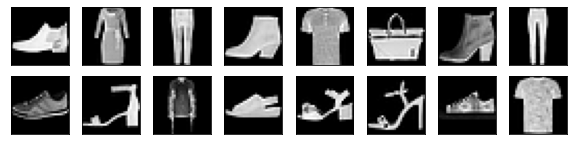

In [5]:
data = []
for i in next(iter(train_loader))[0]:
    data.append (np.array(i[0]*255).astype("uint8"))
plot_digits(np.array(data))

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view((x.size(0),)+self.shape)
    
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(nn.Linear(100,128*7*7),
                                  nn.ReLU(),
                                  Reshape(128,7,7),
                                  nn.UpsamplingNearest2d(scale_factor=2),
                                  nn.Conv2d(128,128,(3,3),padding=1),
                                  nn.BatchNorm2d(128 ,momentum=0.8),
                                  nn.ReLU(),
                                  nn.UpsamplingNearest2d(scale_factor=2),
                                  nn.Conv2d(128,64,(3,3),padding=1),
                                  nn.BatchNorm2d(64, momentum=0.8),
                                  nn.ReLU(),
                                  nn.Conv2d(64,1,(3,3),padding=1),
                                  nn.Tanh()
                                 )

    def forward(self, x):
        return self.main(x)


    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(nn.Conv2d(1, 32, 3, stride=2),
                                  nn.LeakyReLU(0.2),
                                  nn.Dropout2d(0.25),
                                  nn.Conv2d(32, 64, 3, stride=2, padding=1),
                                  nn.ZeroPad2d((1,0,0,1)),
                                  nn.BatchNorm2d(64, momentum=0.8),
                                  nn.LeakyReLU(0.2),

                                  nn.Dropout2d(0.25),
                                  nn.Conv2d(64, 128, 3, stride=2, padding=1),
                                  nn.BatchNorm2d(128, momentum=0.8),
                                  nn.LeakyReLU(0.2),


                                  nn.Dropout2d(0.25),
                                  nn.Conv2d(128, 256, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(256, momentum=0.8),
                                  nn.LeakyReLU(0.2),
                                  nn.Dropout2d(0.25),
                                  nn.Flatten(),
                                  nn.Linear(4096, 2)
                                 )

    def forward(self, x):
        return self.main(x)

In [8]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [9]:
def train(train_loader, model_generator,model_discriminator, optimizerD, optimizerG, epochs, params):
    metric_monitor = MetricMonitor()
    model_generator.train()
    model_discriminator.train()
    stream = tqdm(train_loader)
    for i, data in enumerate(stream, start=1):
        
        image, _ = data
        image = image.to(params["device"], non_blocking=True)

        # Train Discriminator


        model_discriminator.zero_grad()
        noise = np.random.normal(0, 1, (params["half_bath_size"], params["input_dim"])).astype(np.float32)

        syntetic_images = model_generator(torch.tensor(noise).to(params["device"]))

        x_combined = torch.cat((image, syntetic_images))
        y_combined = torch.cat((torch.ones(params["half_bath_size"], dtype=torch.long),
                     torch.zeros(params["half_bath_size"], dtype=torch.long))).to(params["device"])


        logits = model_discriminator(x_combined)

        d_loss_value = nn.CrossEntropyLoss()(logits, y_combined)

        metric_monitor.update("Loss_d", d_loss_value.item())
        optimizerD.zero_grad()
        d_loss_value.backward()
        optimizerD.step()

        # Train Generator

        model_generator.zero_grad()
        noise = torch.tensor(np.random.normal(0, 1, (params["bath_size"], params["input_dim"])).astype(np.float32))
        y_combined = torch.stack((torch.zeros(params["bath_size"], dtype=torch.float32),
                     torch.ones(params["bath_size"], dtype=torch.float32))).T.to(params["device"])

        syntetic = model_generator(noise.to(params["device"]))

        logits = model_discriminator(syntetic)

        criterion = nn.BCEWithLogitsLoss()
        g_loss_value = criterion(logits, y_combined)
        metric_monitor.update("Loss_g", g_loss_value.item())

        optimizerG.zero_grad()
        g_loss_value.backward()
        optimizerG.step()

        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epochs, metric_monitor=metric_monitor)
        )
    return metric_monitor
        

In [10]:
def train_and_validate(model_generator,model_discriminator, train_dataset, val_dataset, params):    
    
    optimizerD = torch.optim.Adam(model_discriminator.parameters(), lr=params["lr"], betas=( 0.5, 0.999))
    optimizerG = torch.optim.Adam(model_generator.parameters(), lr=params["lr"], betas=( 0.5, 0.999))
    for epoch in range(1, params["epochs"] + 1):
        train(train_dataset, model_generator, model_discriminator, optimizerD, optimizerG, epoch, params)
    return model_generator, model_discriminator

In [11]:
params = {
    "device": "cuda:1",
    "lr":  0.0002,
    "num_workers": 8,
    "epochs": 4,
    "half_bath_size":16,
    "bath_size":32,
    "input_dim":100
}

In [21]:
generator = Generator()
discriminator = Discriminator()
generator.apply(weights_init)
discriminator.apply(weights_init)
generator = generator.to(params["device"])
discriminator = discriminator.to(params["device"])

In [29]:
model_generator, model_discriminator = generator, discriminator

In [27]:
model_generator, model_discriminator = train_and_validate(generator, discriminator, train_loader, test_loader ,params)

Epoch: 1. Train.      Loss_d: 0.609 | Loss_g: 0.795: 100%|██████████| 3750/3750 [01:24<00:00, 44.15it/s]
Epoch: 2. Train.      Loss_d: 0.504 | Loss_g: 0.812: 100%|██████████| 3750/3750 [01:24<00:00, 44.14it/s]
Epoch: 3. Train.      Loss_d: 0.454 | Loss_g: 0.787:  27%|██▋       | 1009/3750 [00:23<01:02, 43.58it/s]


KeyboardInterrupt: 

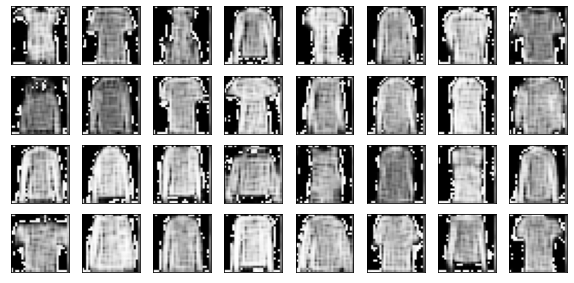

In [30]:
noise = np.random.normal(0, 1, (32, 100)).astype(np.float32)
syntetic_images = model_generator(torch.tensor(noise).to(params["device"]))
plot_digits(np.transpose((syntetic_images.cpu().detach().numpy()*255).astype("uint8"),(0,2,3,1)))

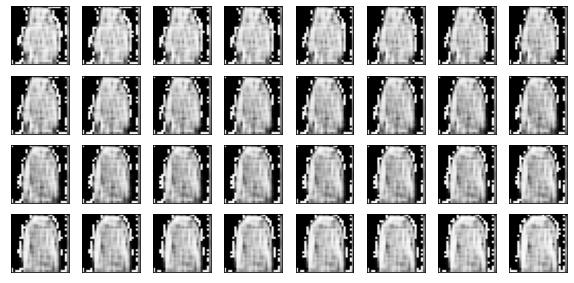

In [36]:
noise_1 = np.random.normal(0, 1, (100)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (100)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = model_generator(torch.tensor(noise).to(params["device"]))
plot_digits(np.transpose((syntetic_images.cpu().detach().numpy()*255).astype("uint8"),(0,2,3,1)))